In [22]:
# https://people.eecs.berkeley.edu/~mlustig/CS/CS_ex.pdf
# https://inst.eecs.berkeley.edu/~ee123/sp16/hw/hw9_Compressed

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

x (128,), t (128,)


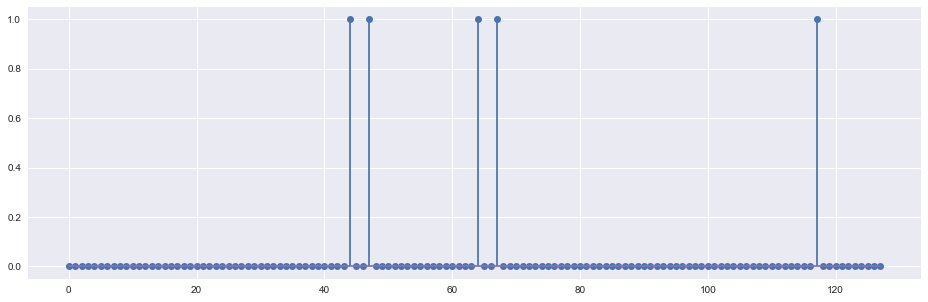

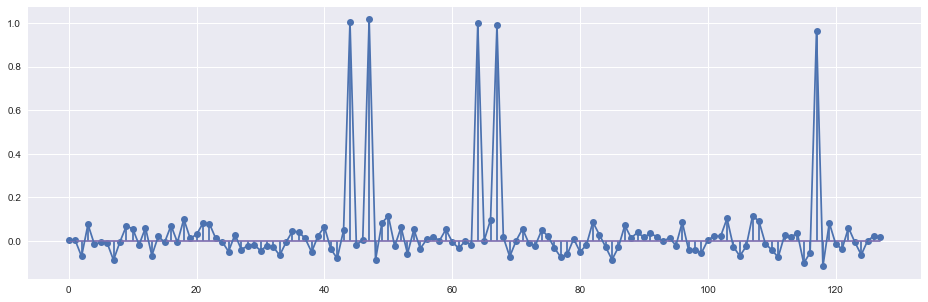

In [23]:
# Sparse Signals
N = 128  # Signal length
k = 5  # Number of non-zero components

# Construct sparse signal
t = np.arange(0, N)
x = np.zeros(N)

np.random.seed(0)
x[np.random.randint(0, N, k)] = 1  # Randomly select non-zero components
print("x {}, t {}".format(str(x.shape), str(t.shape)))

plt.figure(figsize=(16, 5))
plt.stem(t, x, use_line_collection=True)
plt.show()

# Measurement noise
y = x + 0.05 * np.random.normal(size=(N, ))

plt.figure(figsize=(16, 5))
# plt.stem(t, y, use_line_collection=True)
plt.plot(t, y)
plt.show()

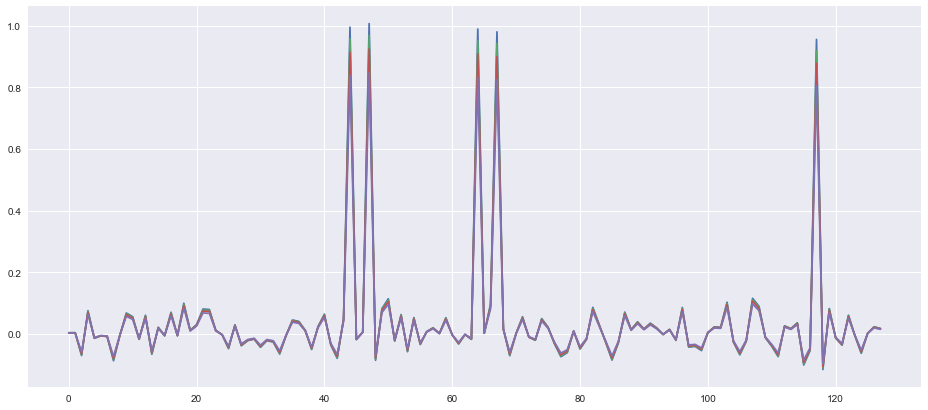

In [24]:
# Tychonov penalty
# Closed form solution

plt.figure(figsize=(16, 7))
for l in [0.01, 0.05, 0.1, 0.2]:
    x_t = 1 / (1 + l) * y
    plt.plot(t, x_t, label=str(l))
    
plt.show()

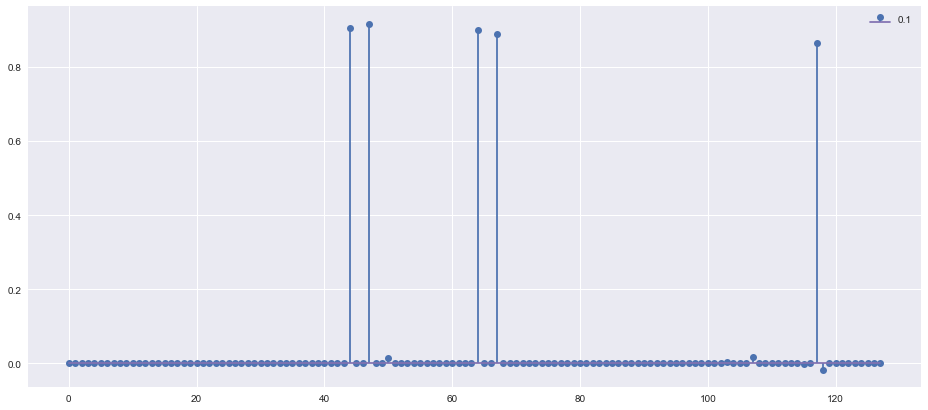

In [76]:
# L1 regularization
# Closed form solution by thresholding
def soft_threshold(y, l):
    x = y.copy()
    x[np.less(np.abs(y), l)] = 0
    x[np.less(y, -l)] = x[np.less(y, -l)] + l
    x[np.greater(y, l)] = x[np.greater(y, l)] - l
    return x


plt.figure(figsize=(16, 7))
# for l in [0.01, 0.05, 0.1, 0.2]:
for l in [0.1]:
    x_l1 = soft_threshold(y, l)

    
    plt.stem(t, x_l1, label=str(l), use_line_collection=True)
    
plt.legend()
plt.show()

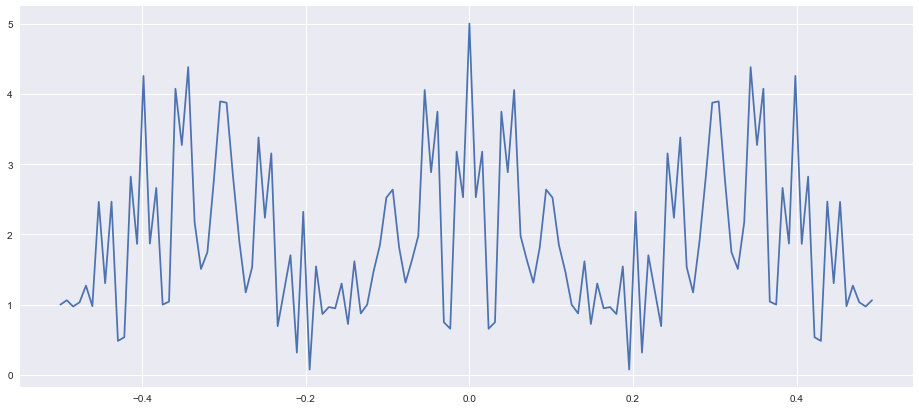

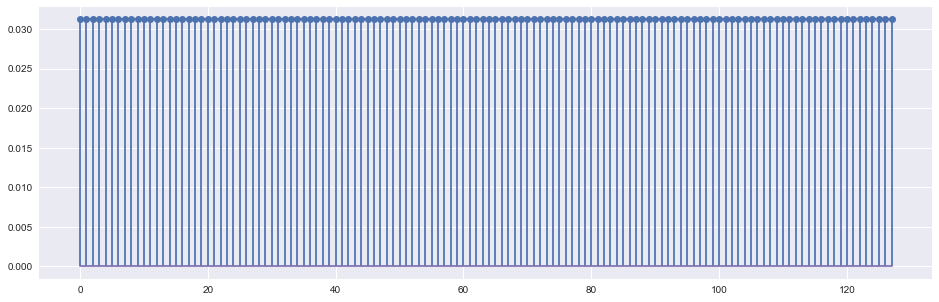

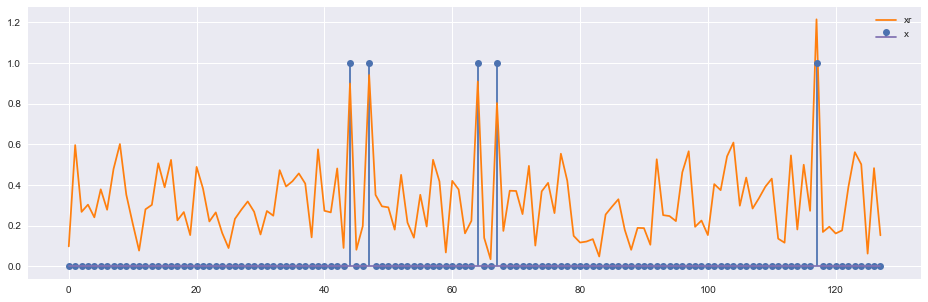

In [58]:
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    F = np.power(np.exp( - 2 * np.pi * 1j / N), i * j )
    return F
F = DFT_matrix(N)  # 128x128 DFT Matrix

# Random Frequency Domain Sampling and Aliasing
X = np.fft.fftshift(np.fft.fft(x))
# X = np.fft.fftshift(np.matmul(F, x))

plt.figure(figsize=(16, 7))
plt.plot(np.fft.fftshift(np.fft.fftfreq(N, d=1)), np.abs(X), label="A")
plt.show()


# Undersampling (Factor 4)
Xu = np.zeros_like(X)
Xu[0:4:N] = X[0:4:N]

# L2 Recovery
Xu = np.fft.ifftshift(Xu)
xu = 4 * np.fft.ifft(Xu)
xu = np.abs(xu)

plt.figure(figsize=(16, 5))
plt.stem(t, xu, label="xu", use_line_collection=True)
plt.plot(t, xu)
plt.show()

# Random Recovery
Xr = np.zeros_like(X)
r_idx = np.random.randint(0, N, N // 4)
Xr[r_idx] = X[r_idx]

# L2 Recovery
Xr = np.fft.ifftshift(Xr)
xr = 4 * np.fft.ifft(Xr)
xr = np.abs(xr)

plt.figure(figsize=(16, 5))
plt.plot(t, xr, label="xr", c="tab:orange")
plt.stem(t, x, label="x", use_line_collection=True)
plt.legend()
plt.show()

F (128, 128), Fu (32, 128)
0 ... 1 ... 2 ... 3 ... 4 ... 5 ... 6 ... 7 ... 8 ... 9 ... 10 ... 11 ... 12 ... 13 ... 14 ... 15 ... 16 ... 17 ... 18 ... 19 ... 20 ... 21 ... 22 ... 23 ... 24 ... 25 ... 26 ... 27 ... 28 ... 29 ... 30 ... 31 ... 32 ... 33 ... 34 ... 35 ... 36 ... 37 ... 38 ... 39 ... 40 ... 41 ... 42 ... 43 ... 44 ... 45 ... 46 ... 47 ... 48 ... 49 ... 50 ... 51 ... 52 ... 53 ... 54 ... 55 ... 56 ... 57 ... 58 ... 59 ... 60 ... 61 ... 62 ... 63 ... 64 ... 65 ... 66 ... 67 ... 68 ... 69 ... 70 ... 71 ... 72 ... 73 ... 74 ... 75 ... 76 ... 77 ... 78 ... 79 ... 80 ... 81 ... 82 ... 83 ... 84 ... 85 ... 86 ... 87 ... 88 ... 89 ... 90 ... 91 ... 92 ... 93 ... 94 ... 95 ... 96 ... 97 ... 98 ... 99 ... 

c:\users\roksi\google drive\projects\cs\venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


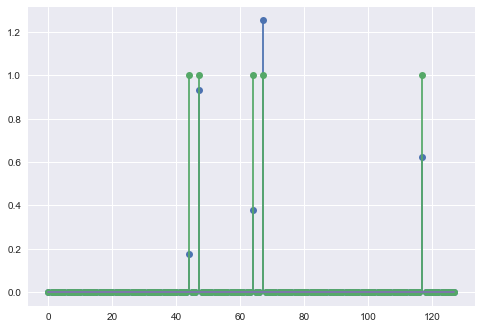

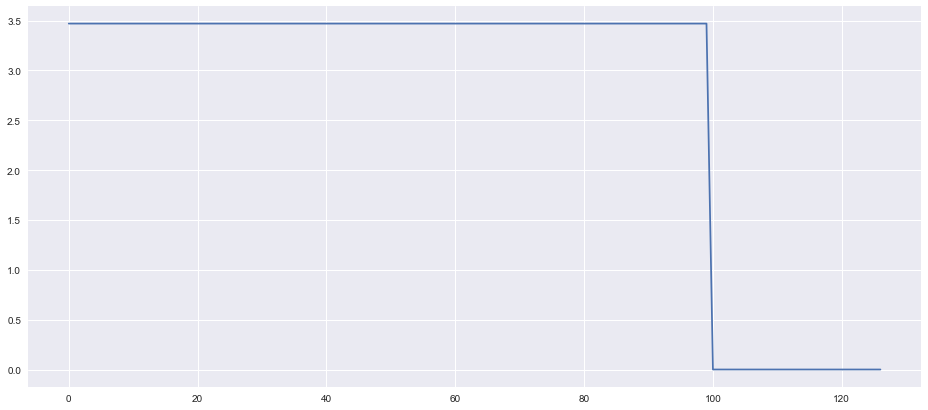

In [110]:
# Reconstruction from randomly sampled frequency domain data
def soft_threshold(x, l):
    x = x.copy()
    x[np.less_equal(np.abs(y), l)] = 0
    idx = np.greater(np.abs(y), l)
    x[idx] = x[idx] * (np.abs(x[idx] - l)) / np.abs(x[idx])
    return x


r_idx = np.random.randint(0, N, N // 4)
Fu = F[r_idx, :]
print("F {}, Fu {}".format(str(F.shape), str(Fu.shape)))

Y = np.matmul(Fu, x)  # Measurements 


# Iterative reconstruction
l = 0.5
Xi = Y  # Initialize

D = np.zeros(N-1)
for idx in range(100):
    print(idx, "...", end=" ")
    
    # Inverse DFT
    xi = np.matmul(Fu.T, Xi) / (N // 4)
    
    # Soft Threshold
    xi = soft_threshold(xi, l)
    
    # DFT
    Xi = np.matmul(Fu, xi)
    
    # Enforce data consistency
    Xi = Xi * np.equal(Y, 0.0) + Y
    
    D[idx] = np.linalg.norm(x - xi)


# Recovered signal
plt.figure()
plt.stem(t, np.abs(xi), use_line_collection=True)
plt.stem(t, x, markerfmt="C1o", linefmt="C1-")
plt.show()

plt.figure(figsize=(16, 7))
plt.plot(D)
plt.show()

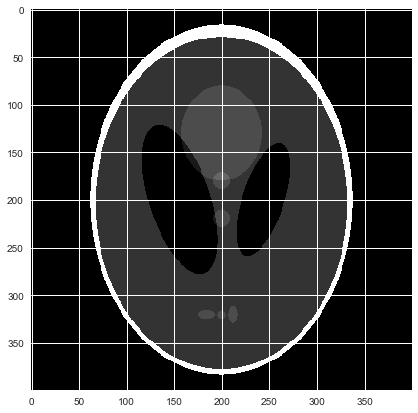

In [111]:
from skimage import data_dir
from skimage.io import imread

I = imread(data_dir + "/phantom.png", as_gray=True)

plt.figure(figsize=(7, 7))
plt.imshow(I, cmap='gray')
plt.show()

In [112]:
import pywt

In [113]:
def imshowgray(im, vmin=None, vmax=None):
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=vmin, vmax=vmax)

    
def wavMask(dims, scale):
    sx, sy = dims
    res = np.ones(dims)
    NM = np.round(np.log2(dims))
    for n in range(int(np.min(NM)-scale+2)//2):
        res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))] = \
            res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))]/2
    return res


def imshowWAV(Wim, scale=1):
    plt.imshow(np.abs(Wim)*wavMask(Wim.shape, scale), cmap = plt.get_cmap('gray'))

    
def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))


def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]

    
def img2coeffs(Wim, levels=4):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs
    
    
def dwt2(im):
    coeffs = pywt.wavedec2(im, wavelet='db4', mode='per', level=4)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim


def idwt2(Wim):
    coeffs = img2coeffs(Wim, levels=4)
    return pywt.waverec2(coeffs, wavelet='db4', mode='per')

Reconstruction error: 7.26607737699601e-14


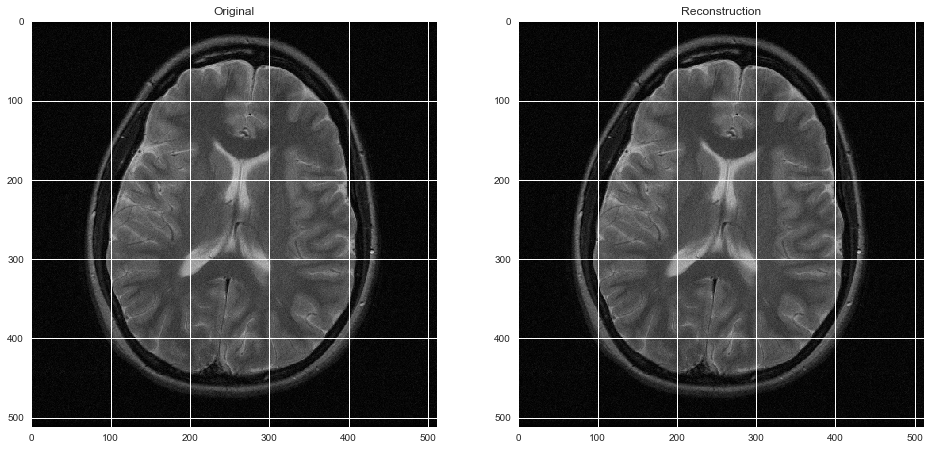

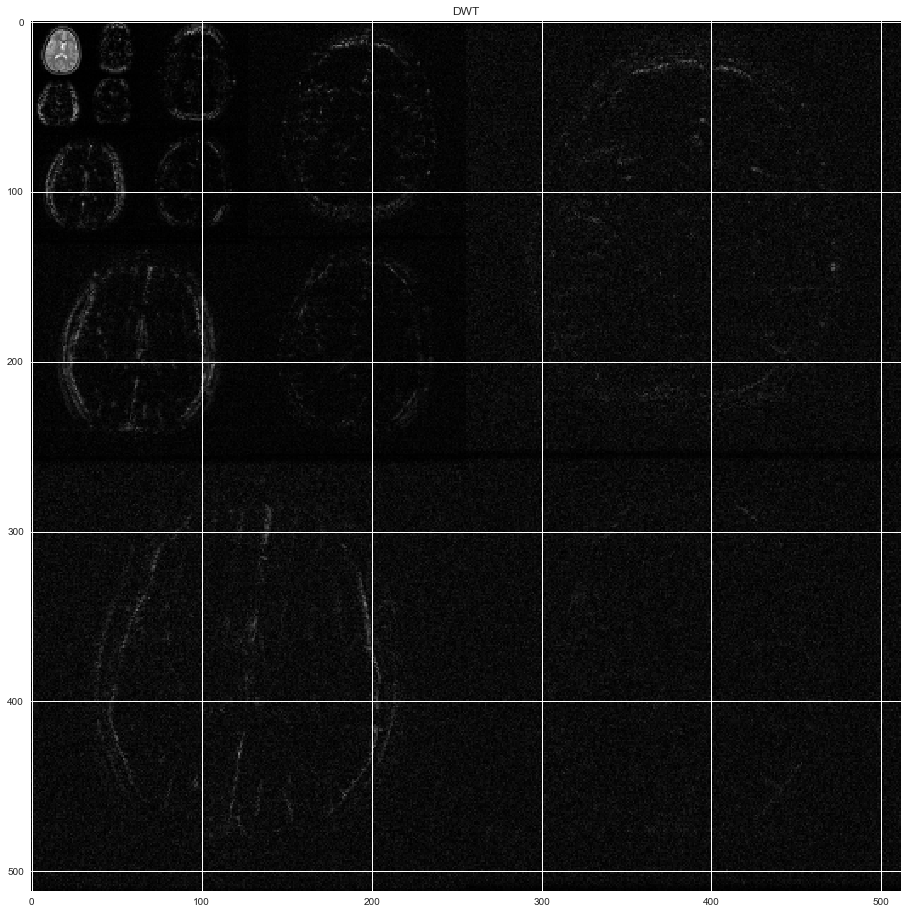

In [123]:
data = np.load("./data/brain.npz")
im, mask_unif, mask_vardens, pdf_unif, pdf_vardens = \
data['im'], data['mask_unif'], data['mask_vardens'], data['pdf_unif'], data['pdf_vardens']

Wim = dwt2(im)
im2 = idwt2(Wim)


plt.figure(figsize=(16, 9))
plt.subplot(1,2,1)
imshowgray(np.abs(im))
plt.title('Original')

plt.subplot(1,2,2)
imshowgray(np.abs(im2))
plt.title('Reconstruction')

plt.figure(figsize=(16, 16))
imshowWAV(Wim)
plt.title('DWT')


print('Reconstruction error:', np.linalg.norm(im - im2))

Reconstruction error: 15.303326958445902


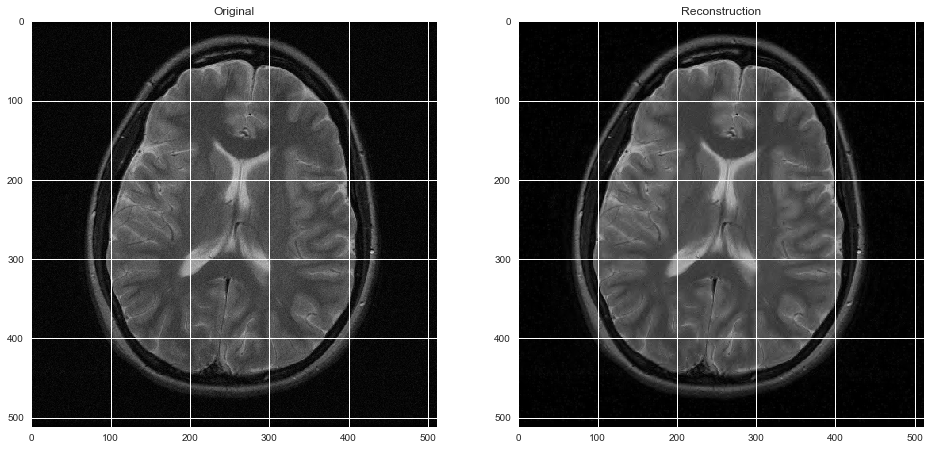

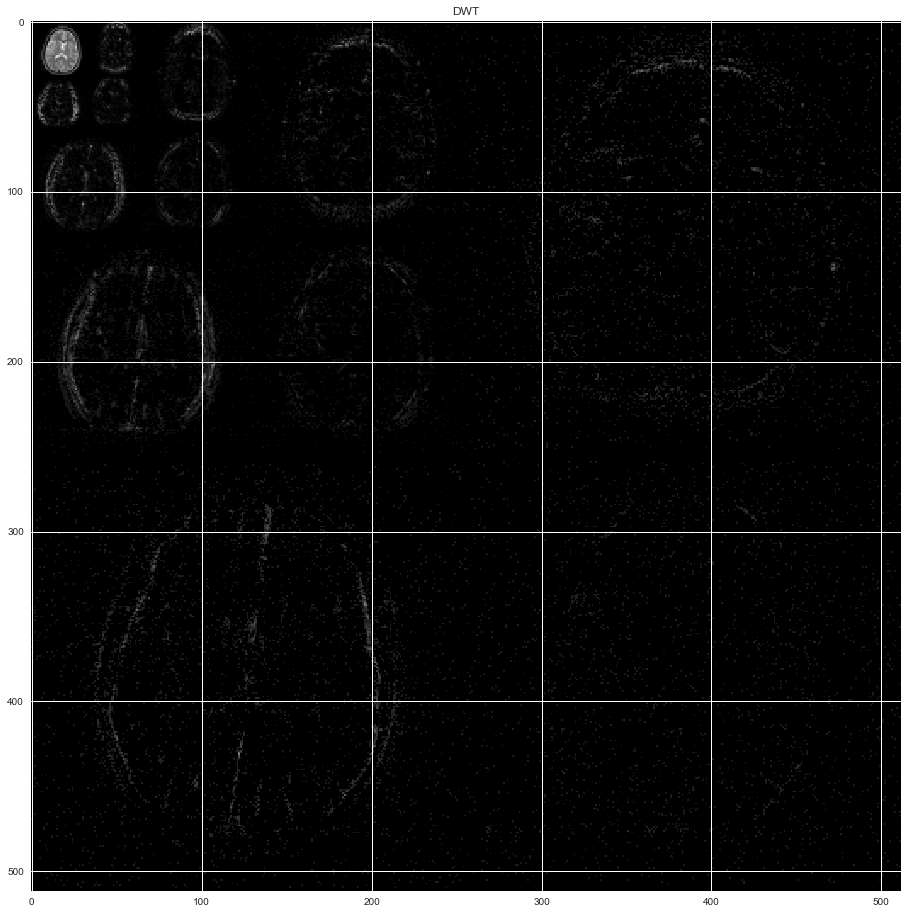

In [130]:
# Wavelet threshold
f = 0.1
m = np.sort(abs(Wim.ravel()))[::-1]
ndx = int(len(m) * f)
thr = m[ndx]
Wim_thr = Wim * (abs(Wim) > thr)

im2 = idwt2(Wim_thr)

plt.figure(figsize=(16, 9))
plt.subplot(1,2,1)
imshowgray(np.abs(im))
plt.title('Original')

plt.subplot(1,2,2)
imshowgray(np.abs(im2))
plt.title('Reconstruction')

plt.figure(figsize=(16, 16))
imshowWAV(Wim_thr)
plt.title('DWT')


print('Reconstruction error:', np.linalg.norm(im - im2))